In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import matplotlib.pyplot
import numpy as np

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
import random

class DataGenerator(keras.utils.Sequence):
    def __init__(self, templates, messages, n_channels=5, sequence_length=50, batch_size=32, shuffle=True):
        self.n_channels = n_channels
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.batch_half_size = batch_size // 2
        self.shuffle=shuffle
        self.character_mappings = {
          'a': [0, 0, 0, 0, 1],
          'b': [0, 0, 0, 1, 0],
          'c': [0, 0, 0, 1, 1],
          'd': [0, 0, 1, 0, 0],
          'e': [0, 0, 1, 0, 1],
          'f': [0, 0, 1, 1, 0],
          'g': [0, 0, 1, 1, 1],
          'h': [0, 1, 0, 0, 0],
          'i': [0, 1, 0, 0, 1],
          'j': [0, 1, 0, 1, 0],
          'k': [0, 1, 0, 1, 1],
          'l': [0, 1, 1, 0, 0],
          'm': [0, 1, 1, 0, 1],
          'n': [0, 1, 1, 1, 0],
          'o': [0, 1, 1, 1, 1],
          'p': [1, 0, 0, 0, 0],
          'q': [1, 0, 0, 0, 1],
          'r': [1, 0, 0, 1, 0],
          's': [1, 0, 0, 1, 1],
          't': [1, 0, 1, 0, 0],
          'u': [1, 0, 1, 0, 1],
          'v': [1, 0, 1, 1, 0],
          'w': [1, 0, 1, 1, 1],
          'x': [1, 1, 0, 0, 0],
          'y': [1, 1, 0, 0, 1],
          'z': [1, 1, 0, 1, 0],
          ' ': [1, 1, 0, 1, 1],
        }
        with open('greetings.txt', 'r') as file:
            self.greetings = file.read().split('\n')
        with open('verbs.txt', 'r') as file:
            self.verbs = file.read().split('\n')
        with open('technologies.txt', 'r') as file:
            self.technologies = file.read().split('\n')
        with open('subjects.txt', 'r') as file:
            self.subjects = file.read().split('\n')
        with open(templates, 'r', encoding='utf-8') as file:
            self.templates = file.read().split('\n')
        with open(messages, 'r', encoding='utf-8') as file:
            self.messages = file.read().split('\n')
        self.on_epoch_end()

    def generate_message(self):
        msg_template = random.choice(self.templates)
        tokens = msg_template.split(' ')
        final = ''
        tech = random.choice(self.technologies)
        if random.randint(0, 2) == 0:
            final += random.choice(self.greetings) + ' '
        for t in tokens:
            if t == '<verb>':
                final += random.choice(self.verbs) + ' '
            elif t == '<subject>':
                final += random.choice(self.subjects) + ' '
            elif t == '<technology>':
                final += tech + ' '
            else:
                final += t + ' '
        return final[:-1]

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.messages))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def mutate(self, msg):
        final = ''
        for e in msg:
            r = random.randint(0, 74) # 1/75 chance of mutation
            if r == 0:
                continue
            elif r == 1:
                final += e + e
            else:
                final += e
        return final

    def vectorize_message(self, msg):
        vec = []
        for c in msg:
            if len(vec) == self.sequence_length * self.n_channels:
                return vec
            if self.character_mappings.get(c) is not None:
                vec += self.character_mappings[c]
        while len(vec) < self.sequence_length * self.n_channels:
            vec += [0, 0, 0, 0, 0]
        return vec

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, self.sequence_length * self.n_channels))

        zeros = np.zeros((self.batch_size // 2))
        ones = np.ones((self.batch_size // 2))

        y = np.concatenate((zeros, ones))
        np.random.shuffle(y)

        itr_fmsg = iter(indexes)
        for index, e in enumerate(y):
            msg = self.mutate(self.generate_message()) if e else self.messages[next(itr_fmsg)]
            X[index] = self.vectorize_message(msg)

        return X, y

    def __len__(self):
        return int((len(self.messages) * 2 / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_half_size:(index+1)*self.batch_half_size]

        X, y = self.__data_generation(indexes)

        return X, y

In [4]:
sequence_length = 50
n_channels = 5
batch_size = 256

params = {
    'n_channels': n_channels,
    'sequence_length': sequence_length,
    'batch_size': batch_size,
    'shuffle': True
}

train_generator = DataGenerator(templates='train_templates.txt', messages='train_messages.txt', **params)
val_generator = DataGenerator(templates='val_templates.txt', messages='val_messages.txt', **params)

In [5]:
import keras_tuner as kt

def model_builder(hp):
    model = keras.Sequential()
    for i in range(hp.Int('layers', 2, 6)):
        model.add(layers.Dense(
            units=hp.Int('units_' + str(i), 10, 100, step=10),
            activation=hp.Choice('act_' + str(i), ['relu', 'elu', 'selu', 'gelu', 'sigmoid']),
            kernel_initializer=hp.Choice('kernel_init_' + str(i), ['he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'zeros', 'ones']),
            bias_initializer='zeros'
        ))
    model.add(layers.Dense(1))
    
    model.compile(
        loss=losses.BinaryCrossentropy(from_logits=True),
        optimizer=optimizers.Adam(learning_rate=1e-5),
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    
    return model

In [6]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=500,
    executions_per_trial=3,
    directory='kt_trials',
    project_name='dontasktoask'
)

In [7]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'gelu', 'sigmoid'], 'ordered': False}
kernel_init_0 (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'zeros', 'ones'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'gelu', 'sigmoid'], 'ordered': False}
kernel_init_1 (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'gl

In [ ]:
tuner.search(train_generator, validation_data=val_generator, epochs=10)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
6                 |6                 |layers
80                |80                |units_0
gelu              |gelu              |act_0
glorot_uniform    |glorot_uniform    |kernel_init_0
80                |80                |units_1
gelu              |gelu              |act_1
he_uniform        |he_uniform        |kernel_init_1

Epoch 1/10


2023-06-18 01:45:42.666746: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


318/318 [==============================] - 3s 7ms/step - loss: 0.7305 - binary_accuracy: 0.5000 - val_loss: 0.6693 - val_binary_accuracy: 0.5000
Epoch 2/10
318/318 [==============================] - 2s 7ms/step - loss: 0.6591 - binary_accuracy: 0.5004 - val_loss: 0.6107 - val_binary_accuracy: 0.5133
Epoch 3/10
318/318 [==============================] - 2s 7ms/step - loss: 0.5935 - binary_accuracy: 0.5592 - val_loss: 0.5296 - val_binary_accuracy: 0.6938
Epoch 4/10
318/318 [==============================] - 2s 7ms/step - loss: 0.5354 - binary_accuracy: 0.7010 - val_loss: 0.4845 - val_binary_accuracy: 0.8102
Epoch 5/10
318/318 [==============================] - 2s 7ms/step - loss: 0.5009 - binary_accuracy: 0.7511 - val_loss: 0.4561 - val_binary_accuracy: 0.8320
Epoch 6/10
318/318 [==============================] - 2s 7ms/step - loss: 0.4783 - binary_accuracy: 0.7697 - val_loss: 0.4521 - val_binary_accuracy: 0.8305
Epoch 7/10
318/318 [==============================] - 2s 7ms/step - loss: 0

In [11]:
model = keras.Sequential()

model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros', input_dim=sequence_length*n_channels))
model.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1))

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=[keras.metrics.BinaryAccuracy()]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               64256     
                                                                 
 dense_13 (Dense)            (None, 16)                4112      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 68,385
Trainable params: 68,385
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_generator, validation_data=val_generator, epochs=100)

Epoch 1/100
20400/20400 [==============================] - 10s 464us/step - loss: 0.4378 - binary_accuracy: 0.7916 - val_loss: 0.3611 - val_binary_accuracy: 0.8470
Epoch 2/100
20400/20400 [==============================] - 9s 458us/step - loss: 0.3203 - binary_accuracy: 0.8597 - val_loss: 0.3189 - val_binary_accuracy: 0.8529
Epoch 3/100
20400/20400 [==============================] - 9s 458us/step - loss: 0.2735 - binary_accuracy: 0.8852 - val_loss: 0.2963 - val_binary_accuracy: 0.8714
Epoch 4/100
20400/20400 [==============================] - 9s 459us/step - loss: 0.2485 - binary_accuracy: 0.8983 - val_loss: 0.2920 - val_binary_accuracy: 0.8701
Epoch 5/100
20400/20400 [==============================] - 9s 458us/step - loss: 0.2278 - binary_accuracy: 0.9099 - val_loss: 0.2850 - val_binary_accuracy: 0.8661
Epoch 6/100
20400/20400 [==============================] - 9s 458us/step - loss: 0.2093 - binary_accuracy: 0.9194 - val_loss: 0.2802 - val_binary_accuracy: 0.8635
Epoch 7/100
20400/204

KeyboardInterrupt: 

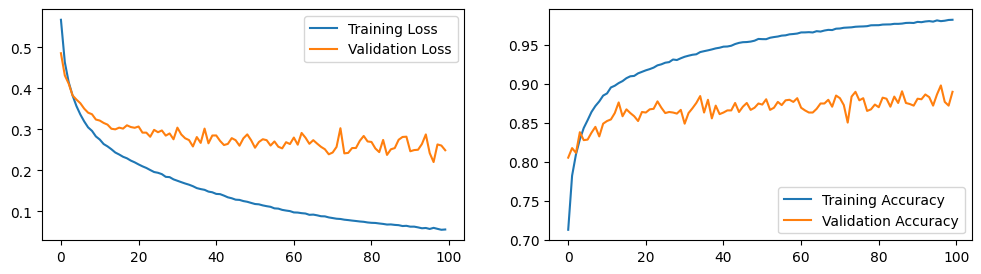

In [9]:
import matplotlib.pyplot as plt

h_dic = history.history

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(h_dic['loss'], label='Training Loss')
plt.plot(h_dic['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h_dic['binary_accuracy'], label='Training Accuracy')
plt.plot(h_dic['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [53]:
export_model = keras.Sequential([
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-4)
)

In [30]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(export_model, 'model/')

ImportError: cannot import name 'load_op' from 'tensorflow.python.data.ops' (/Users/fahd/miniconda/lib/python3.10/site-packages/tensorflow/python/data/ops/__init__.py)

In [54]:
export_model.save('model.h5')